In [13]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

['data/names/Spanish.txt', 'data/names/Korean.txt', 'data/names/French.txt', 'data/names/Chinese.txt', 'data/names/Italian.txt', 'data/names/Russian.txt', 'data/names/Arabic.txt', 'data/names/Dutch.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/Polish.txt', 'data/names/Vietnamese.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/Greek.txt', 'data/names/Czech.txt']


In [14]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [15]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [16]:
print(category_lines['Spanish'][:5])

['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']


In [17]:
import torch

# Find letter index from all_letters eg a = "0"
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a letter into <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into <line_length x 1 x n_letters>,
# or an array of one hot vector encoding
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print (letterToTensor('j'))

print (lineToTensor('Oyesh').size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 55 
    0     0     0     0
[torch.FloatTensor of size 1x56]

torch.Size([5, 1, 56])


In [20]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [19]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.8187 -2.8202 -2.9114 -2.8524 -2.9227 -2.9861 -2.8829 -2.8336 -2.8064 -2.9008

Columns 10 to 17 
-2.9771 -2.9553 -2.8822 -2.8549 -2.9267 -2.9120 -2.8836 -2.9236
[torch.FloatTensor of size 1x18]



In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 12)


In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Werner
category = Portuguese / line = Gomes
category = Japanese / line = Iseya
category = Polish / line = Salomon
category = Arabic / line = Khouri
category = Italian / line = Guerriero
category = Russian / line = Marunin
category = Scottish / line = Stewart
category = Portuguese / line = Souza
category = Portuguese / line = Desantigo


In [11]:
criterion = nn.NLLLoss()

In [12]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 22s) 2.8135 Newton / Scottish ✗ (English)
10000 10% (0m 44s) 1.1272 Handal / Arabic ✓
15000 15% (1m 4s) 3.8093 Haanrath / Irish ✗ (Dutch)
20000 20% (1m 31s) 1.1334 Leeuwenhoek / Dutch ✓
25000 25% (2m 4s) 4.0398 Vo / Vietnamese ✗ (German)
30000 30% (2m 29s) 0.9566 Bekhtin / Russian ✓
35000 35% (2m 55s) 0.9303 Nguyen / Vietnamese ✓
40000 40% (3m 24s) 1.1105 Pereira / Portuguese ✓
45000 45% (3m 54s) 1.5079 Sarkis / Greek ✗ (Arabic)
50000 50% (4m 29s) 1.1036 Romao / Portuguese ✓
55000 55% (5m 0s) 1.9548 Medina / Czech ✗ (Spanish)
60000 60% (5m 33s) 2.1923 Tremblay / English ✗ (French)
65000 65% (6m 2s) 0.2208 Adamoli / Italian ✓
70000 70% (6m 31s) 0.9612 Yuan / Chinese ✓
75000 75% (6m 57s) 1.3931 Bang / Chinese ✗ (Korean)
80000 80% (7m 23s) 0.8895 Hodoval / Czech ✓
85000 85% (7m 55s) 0.0202 Zdunowski / Polish ✓
90000 90% (8m 22s) 1.6940 Macon / English ✗ (French)
95000 95% (8m 51s) 3.1260 Gentile / French ✗ (Italian)
100000 100% (9m 23s) 2.2898 Wicks / Czech ✗ (English)


<IPython.core.display.Javascript object>


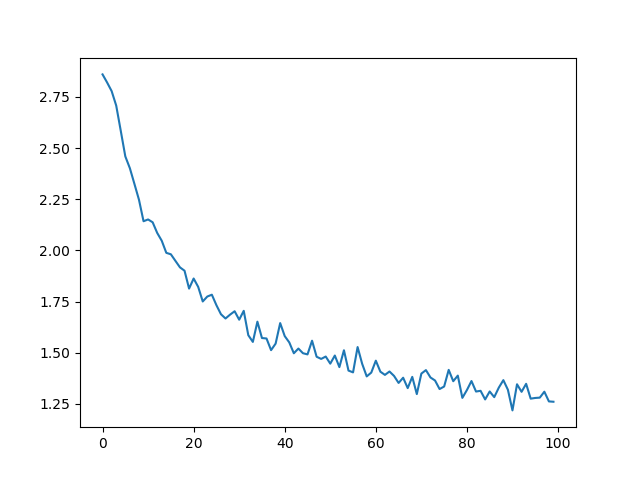

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<IPython.core.display.Javascript object>


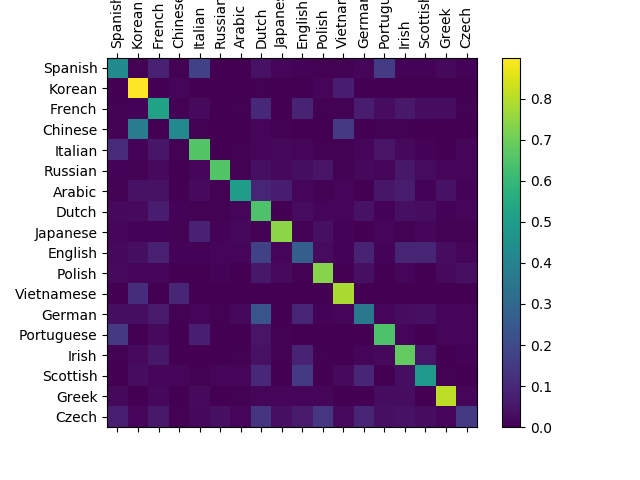

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

In [43]:
predict('Lin')
predict('Adam')
predict('Donald')


> Lin
(-0.96) Korean
(-1.58) Chinese
(-2.07) Vietnamese

> Adam
(-1.54) Irish
(-1.78) Arabic
(-2.21) Dutch

> Donald
(-1.09) Irish
(-1.48) French
(-1.64) English
